# A Sequence Modeling Pipeline with PyTorch for Weather Prediction
# CENG501 - Spring 2023 - PA3

In this task, you are to follow a pipeline for training a recurrent network.

## 1 Import Modules

In [45]:
# Import your modules here
import pandas as pd
import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from torch.utils.data import DataLoader, TensorDataset

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 100

## 2 Dataset

We will use the hourly temperature data for Basel (why Basel? because it was freely available) from [meteoblue](https://www.meteoblue.com/en/weather/archive/export/basel_switzerland_2661604?daterange=2021-06-01%20-%202021-06-23&domain=NEMSAUTO&params%5B%5D=temp2m&min=2021-06-16&max=2021-06-23&utc_offset=2&timeResolution=hourly&temperatureunit=CELSIUS&velocityunit=KILOMETER_PER_HOUR&energyunit=watts&lengthunit=metric&degree_day_type=10%3B30&gddBase=10&gddLimit=30) between 1 June 2021 and 23 June 2021. Here is a description of how you should prepare your dataset from this raw file:

* Raw data is available at [https://ceng.metu.edu.tr/~skalkan/DL/Basel_weather.xlsx](https://ceng.metu.edu.tr/~skalkan/DL/Basel_weather.xlsx) as an XLSX file which was downloaded from [meteoblue](https://www.meteoblue.com/en/weather/archive/export/basel_switzerland_2661604?daterange=2021-06-01%20-%202021-06-23&domain=NEMSAUTO&params%5B%5D=temp2m&min=2021-06-16&max=2021-06-23&utc_offset=2&timeResolution=hourly&temperatureunit=CELSIUS&velocityunit=KILOMETER_PER_HOUR&energyunit=watts&lengthunit=metric&degree_day_type=10%3B30&gddBase=10&gddLimit=30).

* Load the file into Python as a NumPy array using [Pandas](https://pp4e-book.github.io/chapters/ch10_scientific_libraries.html#data-handling-analysis-with-pandas). Filter out unnecessary information at the top and convert the first column to an hour index, starting at 0 and finishing at 551.

* Split the data into two: A training set from the values between 1 June 2021 and 16 June 2021 (inclusive). A test set from the remaining values.

* For each set, slide a time window of six hours and with a stride of 1, and for each position of the window, create a training input-output pair as follows:

  $(\mathbf{x}_i = <T_i, T_{i+1}, T_{i+2}, T_{i+3}, T_{i+4}>, y_i = T_{i+5}),$

  where $T_i$ is the temperature at hour index $i$.


In [46]:
# Loading the excel file
df = pd.read_excel('https://ceng.metu.edu.tr/~skalkan/DL/Basel_weather.xlsx', engine='openpyxl')

# The necessary data starts from row index 9 so filter out the top rows
df = df.iloc[9:]

# Reset the index
df.reset_index(drop=True, inplace=True)

# Rearrange w.r.t. hours
df[df.columns[0]] = np.arange(len(df))

# Split the data into training and testing sets from 16 June 2021. We only need the temperature column
train_data = df.iloc[:384, 1].values
test_data = df.iloc[384:, 1].values

# Reshape the data to fit the scaler
train_data = train_data.reshape(-1, 1)
test_data = test_data.reshape(-1, 1)

# Initialize standard scaler
scaler = StandardScaler()

# Fit the scaler to the training data and transform
train_data = scaler.fit_transform(train_data)

# Apply the scaler to transform the test data
test_data = scaler.transform(test_data)

# Convert back to original shape
train_data = train_data.reshape(-1)
test_data = test_data.reshape(-1)

# Function to create sequences
def create_sequences(dataset, seq_length=5):
    dataX = np.zeros((len(dataset)-seq_length, seq_length))
    dataY = np.zeros((len(dataset)-seq_length, 1))
    for i in range(len(dataset)-seq_length):
        dataX[i] = dataset[i:i+seq_length]
        dataY[i] = dataset[i+seq_length]
    return dataX, dataY

# Create sequences
seq_length = 5
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# Convert to tensors
X_train = torch.tensor(X_train).float().unsqueeze(2)
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float().unsqueeze(2)
y_test = torch.tensor(y_test).float()

# Convert to datesets
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)


## 3 Your LSTM Definition

Implement your own LSTM "cell" using PyTorch without using PyTorch's LSTM implementation. However, you can use the backpropagation (gradient computation) mechanism of PyTorch and therefore, you just need to worry about feedforward processing.

Your implementation should not be limited to the weather prediction problem and be general. For the sake of simplicity, you can just implement a single-layer LSTM cell.

In [47]:
class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True):
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        
        # Batch normalization layer
        self.bn = nn.BatchNorm1d(4 * hidden_size)

        # Initialize weights and biases for the input and hidden layers
        self.weight_ih = nn.Parameter(torch.Tensor(4 * hidden_size, input_size))
        self.weight_hh = nn.Parameter(torch.Tensor(4 * hidden_size, hidden_size))
        if bias:
            self.bias_ih = nn.Parameter(torch.Tensor(4 * hidden_size))
            self.bias_hh = nn.Parameter(torch.Tensor(4 * hidden_size))
        else:
            self.register_parameter('bias_ih', None)
            self.register_parameter('bias_hh', None)

        # Initialize weights and biases with uniform distribution over one standart deviation in magnitude
        self.reset_parameters()

    def reset_parameters(self):
        std = 1.0 / math.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, input, hc_0):
        # Get hidden state and cell state from the previous time step
        h_0, c_0 = hc_0

        # Compute gates
        gates = F.linear(input, self.weight_ih, self.bias_ih) + F.linear(h_0, self.weight_hh, self.bias_hh)

        # Apply batch normalization
        gates = self.bn(gates)

        # Chunk the gates into 4: input, forget, cell and output gates 
        input_gate, forget_gate, cell_gate, output_gate = gates.chunk(4, 1)

        # Apply activations
        input_gate = torch.sigmoid(input_gate)
        forget_gate = torch.sigmoid(forget_gate)
        cell_gate = torch.tanh(cell_gate)
        output_gate = torch.sigmoid(output_gate)

        # Compute new cell state and hidden state
        c_1 = forget_gate * c_0 + input_gate * cell_gate
        h_1 = output_gate * torch.tanh(c_1)

        return h_1, c_1

## 4 Your Sequence Model for Weather Prediction

In [48]:
class WeatherPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1):
        super(WeatherPredictor, self).__init__()
        self.lstm = LSTMCell(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, input):
        # Initialize the hidden and cell states
        h = torch.zeros(input.size(0), self.lstm.hidden_size)
        c = torch.zeros(input.size(0), self.lstm.hidden_size)

        # Process the input sequence
        for i in range(input.size(1)):
            h, c = self.lstm(input[:, i], (h, c))

        # Predict the next temperature
        output = self.linear(h)
        return output

## 5 Your Trainer

Implement your training function here. You can use functions we have defined in the previous assignments.

In [49]:
def train(model, criterion, optimizer, num_epochs, train_data, batch_size):
  loss_history = []
  
  # Batch train data
  train_loader = DataLoader(dataset=train_data, batch_size=batch_size, drop_last=True)

  for epoch in range(num_epochs):
    model.train()
    for data, target in train_loader:
      output = model(data)
      loss = criterion(output, target)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      loss_history.append(loss.item())

    if (epoch+1) % num_epochs//2 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

  return loss_history

## 6 Train Your Model

Create an instance of your model, a suitable loss function, a suitable optimizer and call the training function with suitable hyperparameters (learning rate, batch size, hidden size etc.).

In [50]:
# Define the model
model = WeatherPredictor(input_size=1, hidden_size=50)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Train the model
num_epochs = 20
batch_size= 64
loss_history = train(model, criterion, optimizer, num_epochs, train_data, batch_size)

Epoch [1/20], Loss: 0.7557
Epoch [20/20], Loss: 0.0201


## 7 Analyze the Results

### 7.1 Visualize the Loss Curve

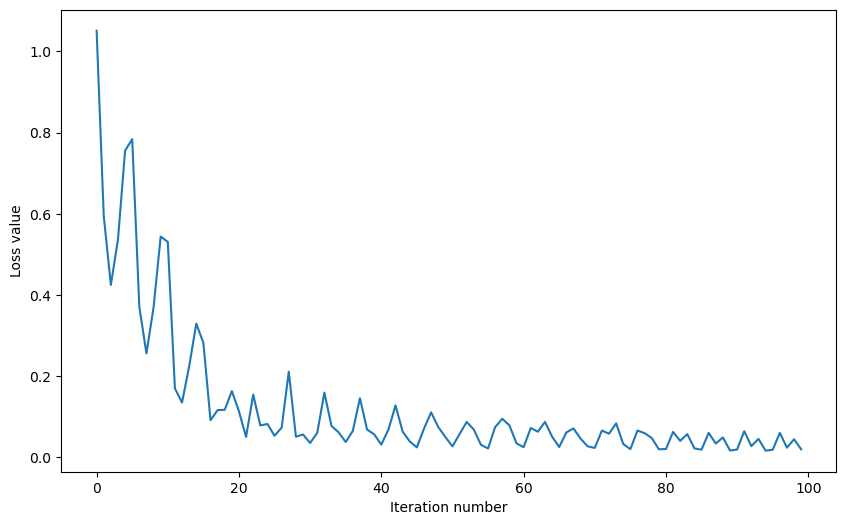

In [51]:
plt.plot(loss_history)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

### 7.2 Quantitative Analysis

Provide a quantitative analysis of your model on the test set using root mean squared error.

In [52]:
# Test the model
model.eval()
with torch.no_grad():
    predictions = model(X_test)
    loss = criterion(predictions, y_test)

# Inverse the scaling for predictions and y_test to compute the loss and plot the predictions
# Detach the predictions tensor and convert to numpy array
predictions_view = predictions.detach().numpy()

# Inverse transform the predictions and reshape the predictions to plot it
predictions_view = scaler.inverse_transform(predictions_view).reshape(-1)

# Same steps for y_test
y_test_view = y_test.detach().numpy()
y_test_view = scaler.inverse_transform(y_test_view).reshape(-1)

# Compute the mean squared error (MSE)
mse = mean_squared_error(y_test_view, predictions_view)

# Compute the root mean squared error (RMSE)
rmse = np.sqrt(mse)

print(f"RMSE: {rmse}")

RMSE: 1.0621671676635742


### 7.3 Qualitative Analysis

Plot test data and your predictions over a sliding window. Plot two versions of your predictions:

(i) Slide a window on the test data, and plot the predictions only.

(ii) Use only the first window of the test data, let's denote this with $<T_0, T_{1}, T_{2}, T_{3}, T_{4}>$. After obtaining the first prediction $T'_{5}$ on this window, make your second prediction by sliding the window to include the new prediction, i.e., taking as input $<T_{1}, T_{2}, T_{3}, T_{4}, T_{5}'>$. Continue in this fashion to obtain the same number of predictions as the size of the test data.

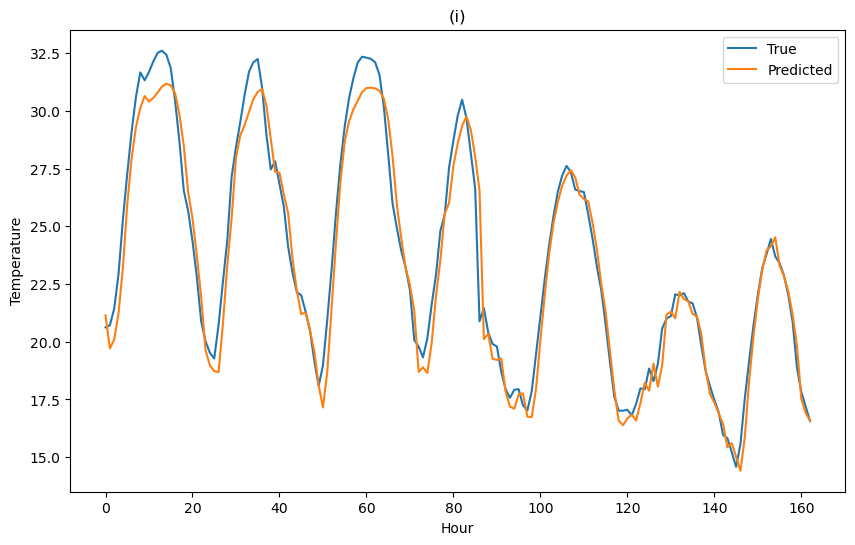

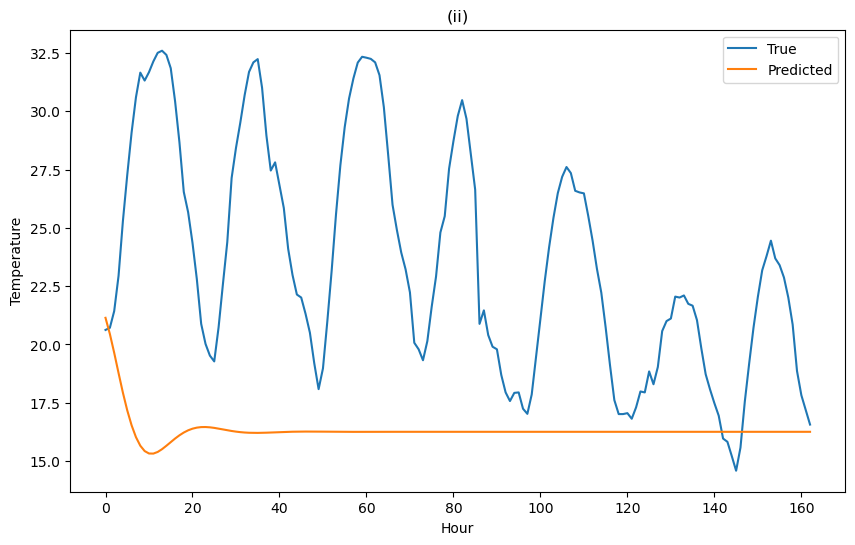

In [53]:
# (i)

# Plot the predictions against the real values (y_test_view)
plt.figure()
plt.plot(range(len(y_test_view)), y_test_view, label='True')
plt.plot(range(len(predictions_view)), predictions_view, label='Predicted')
plt.title("(i)")
plt.xlabel("Hour")
plt.ylabel("Temperature")
plt.legend()
plt.show()

# (ii)

# Initialize the sequence input with the first window of the test data
sequence_input = X_test[0, :].unsqueeze(0)

# List to store the model's predictions
predictions = []

# Set the model to evaluation mode
model.eval()

# Loop over the length of the test data
for _ in range(len(X_test)):

    # Compute the model's prediction for the current input sequence
    with torch.no_grad():
        prediction = model(sequence_input)

    # Append the prediction to the list of predictions
    predictions.append(prediction.item())

    # Slide the input sequence window to the right
    # Discard the oldest value in the sequence, and append the newest prediction
    sequence_input = torch.cat((sequence_input[0, 1:], prediction)).unsqueeze(0)

# Convert the list of predictions to a NumPy array
predictions = np.array(predictions)

# Inverse transform the predictions and reshape the predictions to plot it
predictions = scaler.inverse_transform(predictions.reshape(-1, 1)).reshape(-1)


# Plot the predictions against the real values (y_test)
plt.figure()
plt.plot(y_test_view, label='True')
plt.plot(predictions, label='Predicted')
plt.title("(ii)")
plt.xlabel("Hour")
plt.ylabel("Temperature")
plt.legend()
plt.show()

## 8 Tune Your Model

Tune the following aspects for your model and provide a figure or a table in each case:

- Number of hidden neurons.
- Learning rate.
- Batch size.

Report the performance of the best model after tuning.

In [54]:
# Uncomment to install optuna if not installed yet
# ! pip install optuna

[I 2023-06-18 21:11:20,038] A new study created in memory with name: no-name-b800c1f4-e77e-4d57-8be2-b362938aa1cc
/var/folders/7g/23wk5skn7gn2hdksw36wfw240000gn/T/ipykernel_31695/205569324.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lr', 1e-3, 1e-1)


Epoch [1/20], Loss: 0.9996


[I 2023-06-18 21:11:21,482] Trial 0 finished with value: 0.3203745484352112 and parameters: {'hidden_size': 58, 'lr': 0.07728006705260716, 'batch_size': 32}. Best is trial 0 with value: 0.3203745484352112.


Epoch [20/20], Loss: 0.1247
Epoch [1/20], Loss: 0.6300


[I 2023-06-18 21:11:22,204] Trial 1 finished with value: 0.03850775957107544 and parameters: {'hidden_size': 56, 'lr': 0.005708053976276976, 'batch_size': 64}. Best is trial 1 with value: 0.03850775957107544.


Epoch [20/20], Loss: 0.0715
Epoch [1/20], Loss: 1.0503


[I 2023-06-18 21:11:23,319] Trial 2 finished with value: 0.3232179880142212 and parameters: {'hidden_size': 55, 'lr': 0.010766185695548257, 'batch_size': 16}. Best is trial 1 with value: 0.03850775957107544.


Epoch [20/20], Loss: 0.2299
Epoch [1/20], Loss: 0.8566


[I 2023-06-18 21:11:24,872] Trial 3 finished with value: 0.34405985474586487 and parameters: {'hidden_size': 51, 'lr': 0.04710686136233262, 'batch_size': 32}. Best is trial 1 with value: 0.03850775957107544.


Epoch [20/20], Loss: 0.0719
Epoch [1/20], Loss: 0.4444


[I 2023-06-18 21:11:25,572] Trial 4 finished with value: 0.13479070365428925 and parameters: {'hidden_size': 50, 'lr': 0.04391158948113389, 'batch_size': 64}. Best is trial 1 with value: 0.03850775957107544.


Epoch [20/20], Loss: 0.0315
Epoch [1/20], Loss: 1.0662


[I 2023-06-18 21:11:26,925] Trial 5 finished with value: 0.38583463430404663 and parameters: {'hidden_size': 59, 'lr': 0.008421049139738294, 'batch_size': 16}. Best is trial 1 with value: 0.03850775957107544.


Epoch [20/20], Loss: 0.2179
Epoch [1/20], Loss: 0.9790


[I 2023-06-18 21:11:28,247] Trial 6 finished with value: 0.7979294061660767 and parameters: {'hidden_size': 58, 'lr': 0.06085683957732289, 'batch_size': 16}. Best is trial 1 with value: 0.03850775957107544.


Epoch [20/20], Loss: 0.2140
Epoch [1/20], Loss: 0.2521


[I 2023-06-18 21:11:30,551] Trial 7 finished with value: 0.7518807649612427 and parameters: {'hidden_size': 55, 'lr': 0.005131796628362799, 'batch_size': 8}. Best is trial 1 with value: 0.03850775957107544.


Epoch [20/20], Loss: 0.0161
Epoch [1/20], Loss: 0.5137


[I 2023-06-18 21:11:31,026] Trial 8 finished with value: 0.31055134534835815 and parameters: {'hidden_size': 55, 'lr': 0.00224491182776631, 'batch_size': 128}. Best is trial 1 with value: 0.03850775957107544.


Epoch [20/20], Loss: 0.0739
Epoch [1/20], Loss: 0.8054


[I 2023-06-18 21:11:33,377] Trial 9 finished with value: 0.7910516858100891 and parameters: {'hidden_size': 56, 'lr': 0.034817166889439206, 'batch_size': 8}. Best is trial 1 with value: 0.03850775957107544.


Epoch [20/20], Loss: 0.1480
Best hyperparameters: {'hidden_size': 56, 'lr': 0.005708053976276976, 'batch_size': 64}
Epoch [1/20], Loss: 0.7827
Epoch [20/20], Loss: 0.0172
RMSE: 0.9868357181549072


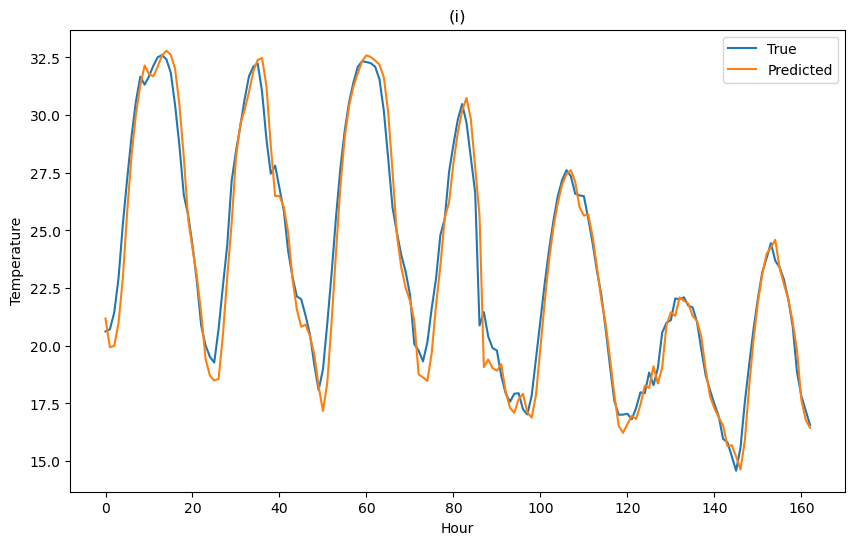

In [55]:
import optuna

# Split the data into training and validation sets
# I did not use the random splitting in order to keep the order of the data
split_idx = int(0.8 * X_train.shape[0]) # 80% of the data for training, 20% for validation

X_train_new = X_train[:split_idx, :, :]
y_train_new = y_train[:split_idx, :]
train_data_new = TensorDataset(X_train_new, y_train_new)

X_val = X_train[split_idx:, :, :]
Y_val = y_train[split_idx:, :]
input_size = 1

def objective(trial):
    # Suggest the hyperparameters
    hidden_size = trial.suggest_int('hidden_size', 50, 60)
    learning_rate = trial.suggest_loguniform('lr', 1e-3, 1e-1)
    batch_size = trial.suggest_categorical('batch_size', [8, 16, 32, 64, 128])


    # Train the model
    model = WeatherPredictor(input_size, hidden_size)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train(model, criterion, optimizer, num_epochs, train_data_new, batch_size)
    
    # Evaluate the model
    model.eval()
    with torch.no_grad():
        predictions = model(X_val)
        loss = criterion(predictions, Y_val)

    return loss.item()

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# Get the best hyperparameters
best_params = study.best_params
print(f"Best hyperparameters: {best_params}")

# Train the model with the optimal hyperparameters
best_model = WeatherPredictor(input_size=1, hidden_size=best_params['hidden_size'])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(best_model.parameters(), lr=best_params['lr'])
train(best_model, criterion, optimizer, num_epochs, train_data, best_params['batch_size'])

# Test the suggested best model
best_model.eval()
with torch.no_grad():
    predictions_best = best_model(X_test)
    loss = criterion(predictions_best, y_test)

# Detach the predictions tensor and convert to numpy array
predictions_view = predictions_best.detach().numpy()
# Inverse transform the predictions and reshape the predictions to plot it
predictions_view = scaler.inverse_transform(predictions_view).reshape(-1)
# Same steps for y_test
y_test_view = y_test.detach().numpy()
y_test_view = scaler.inverse_transform(y_test_view).reshape(-1)
# Compute the mean squared error 
mse = mean_squared_error(y_test_view, predictions_view)
# Compute the root mean squared error 
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")

# Plot the predictions against the real values (y_test_view)
plt.figure()
plt.plot(y_test_view, label='True')
plt.plot(predictions_view, label='Predicted')
plt.title("(i)")
plt.xlabel("Hour")
plt.ylabel("Temperature")
plt.legend()
plt.show()


***Comment:*** In some runs, the error is a little bit higher after hyperparameter optimization compared to before optimization. 
This might be because the training set is restricted to only 80% of the total data during the optimization phase.